# Multiclass Support Vector Machine

**This material is heavily based on the popular Standford CS231n lecture material.** [Please check on their website for more detailed information](https://cs231n.github.io/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size": 10,
})

from utils import *

## Class SVM

In [2]:
from utils import * 

class SVM():
    def __init__(self):
        self.W = None

    
    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=True):
        '''
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        '''
          
        num_train, dim = X.shape
        num_classes = len(np.unique(y)) 
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # Sample batch_size elements from the training data and their           
            # corresponding labels to use in this round of gradient descent.        
            # Store the data in X_batch and their corresponding labels in           
            # y_batch; after sampling X_batch should have shape (dim, batch_size)   
            # and y_batch should have shape (batch_size,)                           
            
            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # evaluate loss and gradient
            loss, grad = svm_loss(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          
            self.W = self.W - learning_rate * grad
     
            if verbose and it % 10 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            if loss < 1.0:
                break

        return loss_history
    

    def predict(self, X, k=1, L=2):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)

        return y_pred


## Breast Cancer Wisconsin

We are going to use the Diagnostic Wisconsin breast cancer dataset is available in public domain.

We obtained the dataset from the following link:  

https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic


This dataset is also available in scikit-learn:  

https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.load_breast_cancer.html

The original labels are characters: `M` and `B`. For the SVM to work, the labels must be numbers. Hence, we change the labels:
* `M` is replaced with `1`
* `B` is replaced with `0`

In [3]:
data = np.loadtxt("./datasets/breast_cancer/wdbc.data", delimiter=",", dtype=str)
X = np.float32(data[:, 2:])  # 10 dimensions

# Diagnosis (M = malignant, B = benign)
y = np.zeros(X.shape[0], dtype=np.int32) 
y[np.where(data[:,1]=='M')] = 1
y[np.where(data[:,1]=='B')] = 0

print("Dimension numbers :", X.shape[1])
print("Number of data    :", X.shape[0])
print("Labels            :", np.unique(y))

Dimension numbers : 30
Number of data    : 569
Labels            : [0 1]


In [4]:
X_train = X[0:400, :]
y_train = y[0:400]
X_test  = X[401:, :]
y_test  = y[401:]

num_test = X_test.shape[0]

In [5]:
classifier = SVM()
loss_hist = classifier.train(X_train, y_train, num_iters=10000)

iteration 0 / 10000: loss 1.784581
iteration 10 / 10000: loss 462.868756
iteration 20 / 10000: loss 363.492101
iteration 30 / 10000: loss 167.398950
iteration 40 / 10000: loss 369.175356
iteration 50 / 10000: loss 17.617184
iteration 60 / 10000: loss 386.623835
iteration 70 / 10000: loss 308.352671
iteration 80 / 10000: loss 87.915069
iteration 90 / 10000: loss 101.372292
iteration 100 / 10000: loss 29.703263
iteration 110 / 10000: loss 17.998642
iteration 120 / 10000: loss 131.297833
iteration 130 / 10000: loss 148.432137
iteration 140 / 10000: loss 81.965541
iteration 150 / 10000: loss 84.479955
iteration 160 / 10000: loss 69.091878
iteration 170 / 10000: loss 15.848667
iteration 180 / 10000: loss 8.246587
iteration 190 / 10000: loss 13.840735
iteration 200 / 10000: loss 13.663609
iteration 210 / 10000: loss 11.517691
iteration 220 / 10000: loss 16.811609
iteration 230 / 10000: loss 10.883426
iteration 240 / 10000: loss 13.705744
iteration 250 / 10000: loss 8.197055
iteration 260 / 1

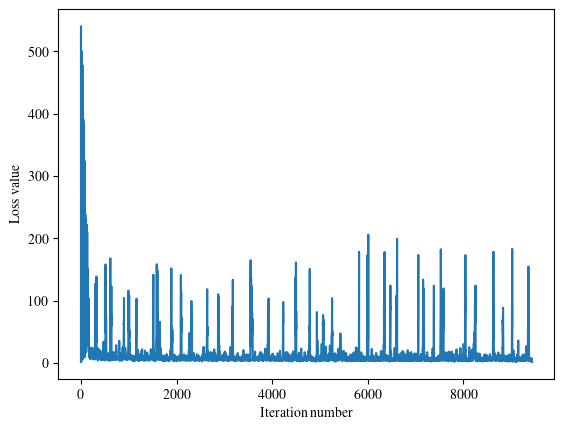

In [6]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [7]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = classifier.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_test_pred = classifier.predict(X_test)
print('validation accuracy: %f' % (np.mean(y_test == y_test_pred), ))

training accuracy: 0.917500
validation accuracy: 0.892857
